In [532]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtk

import warnings
warnings.filterwarnings("ignore")

In [533]:
diagnostics = False

### Main function

In [534]:
def main(atmosphere='CIRC2', gas=None, bands='all', dT=0):
    
    if atmosphere.lower() == 'circ2':
        T_s = 307.74 + dT
    elif atmosphere.lower() == 'circ4':
        T_s = 266.55 + dT
    
    if bands == 'all':
        bands = range(1, 15)
    elif type(bands) is not list:
        bands = [bands]
    
    F_total = 0
    
    for band in bands[::-1]:
        if diagnostics:
            print('Band {0}'.format(band))
        band_data = band_info(band=band)
        wavelengths = [1/band_data['min'], 1/band_data['max']]

        F = flux(T_s, wavelengths)
        F_total += F
        
    return F_total

### Auxiliary functions

#### Flux in a layered atmosphere

Reference Lecture 3, Slide 19 from David Paynter

In [564]:
def flux_layered(atmosphere='CIRC2', gas_name='ALLGAS', bands='all', z='sfc', custom_temps=None):
    
    transmittance_data = load(atmosphere=atmosphere, gas_name=gas_name)
    
    if bands == 'all':
        bands = range(1, 15)
    elif type(bands) is not list:
        bands = [bands]
    
    # Initialize flux as 0
    F = 0
    
    # Iterate over each band
    for band in bands:
        # Get data for iterand band
        band_data = band_info(band=band)
        # Get wavelength bounds for the band
        wavelengths = [1/band_data['min'], 1/band_data['max']]

        ''' Handle TOA fluxes. '''
        # Term 1: Surface flux (intensity at surface * transmittance over depth of atmosphere)
        # Term 2: Atmospheric layer fluxes (intensity at layer * transmittance over layer)
        # Term 3: TOA fluxes (intensity at TOA * transmittance at TOA)
        if z.lower() == 'toa':
            # Get transmittance data at TOA
            transmittance_data = transmittance_data.loc[transmittance_data['level'] == z.upper()]
            
            if custom_temps:
                transmittance_data['layer_temp'] = custom_temps
            
            # Get surface and TOA temperatures. This assumes that DataFrame is sorted by ascending height
            T_s, T_toa = transmittance_data.iloc[0]['layer_temp'], transmittance_data.iloc[-1]['layer_temp']
    
            # Calculate first term in equation for F_{TOA} from Slide 19 of David Paynter's Lecture 3
            # term_1 = flux(T_s, wavelengths, N=100)*(transmittance_data.iloc[-1]['tb_{0}'.format(band)] - transmittance_data.iloc[0]['tb_{0}'.format(band)])
            term_1 = flux(T_s, wavelengths, N=100)*(transmittance_data['tb_{0}'.format(band)].prod())
            
            # Initialize term 2 flux (summation term from equation for F_{TOA} from Slide 19 of David Paynter's Lecture 3)
            term_2 = 0
            # Summation from top to bottom level, descending in height
            for i in range(len(transmittance_data['layer_pres'])-1, 2, -1):
                term_2_T = transmittance_data.iloc[i-1]['layer_temp']
                term_2_F = flux(term_2_T, wavelengths, N=100)
                term_2_tb = transmittance_data.iloc[i:-1]['tb_{0}'.format(band)].prod() - transmittance_data.iloc[(i-1):-1]['tb_{0}'.format(band)].prod()
                
                term_2 += term_2_F*term_2_tb

            # Calculate third term in equation for F_{TOA} from Slide 19 of David Paynter's Lecture 3
            term_3 = flux(T_toa, wavelengths, N=100)*(1 - transmittance_data.iloc[-1]['tb_{0}'.format(band)])

            F += term_1 + term_2 + term_3
    
        ''' Handle surface fluxes. '''
        # Term 1: Surface flux (intensity at surface * transmittance over depth of atmosphere)
        # Term 2: Atmospheric layer fluxes (intensity at layer * transmittance over layer)
        # Term 3: TOA fluxes (intensity at TOA * transmittance at TOA)
        if z.lower() == 'sfc':
            # Get transmittance data at surface
            transmittance_data = transmittance_data.loc[transmittance_data['level'] == z.upper()]
            
            if custom_temps:
                transmittance_data['layer_temp'] = custom_temps
            
            # Get surface and TOA temperatures. This assumes that DataFrame is sorted by ascending height
            T_s, T_toa = transmittance_data.iloc[0]['layer_temp'], transmittance_data.iloc[-1]['layer_temp']

            # Initialize term 1 flux (summation term from equation for F_{SFC} from Slide 19 of David Paynter's Lecture 3)
            term_1 = 0
            # Summation from bottom to top level, ascending in height
            for i in range(1, len(transmittance_data['layer_pres'])-1):
                term_1_T = transmittance_data.iloc[i+1]['layer_temp']
                term_1_F = flux(term_1_T, wavelengths, N=100)
                term_1_tb = transmittance_data.iloc[1:i]['tb_{0}'.format(band)].prod() - transmittance_data.iloc[1:(i+1)]['tb_{0}'.format(band)].prod()
                term_1 += term_1_F*term_1_tb
                
            # Calculate second term in equation for F_{SFC} from Slide 19 of David Paynter's Lecture 3
            T_1 = transmittance_data['layer_temp'].loc[transmittance_data['layer_pres'].idxmax()+1]
            term_2 = flux(T_1, wavelengths, N=100)*(1 - transmittance_data.iloc[0]['tb_{0}'.format(band)])
            
            # print('Band {0:4} - vertical contribution: {1:.2e} W m^-2 | toa contribution: {2:.2e} W m^-2'.format(band, term_1, term_2))


            F += term_1 + term_2
    
    return F

#### Flux discretization function
Integrates flux for a temperature over a given range of wavelengths using the trapezoidal method over $N$ intervals.

In [536]:
def flux(T, wavelengths, N=500):
    # Get wavelength limits for the band
    wavelength_max, wavelength_min = wavelengths
    # Override fluxes for the last interval (lowest wavenumber, largest wavelength)
    if wavelength_max == np.inf:
        wavelength_max = 1e-2
        
    if diagnostics:
        print('\t Wavelength min.: {0:8.2e} m, Wavelength max.: {1:8.2e} m,'.format(wavelength_min, wavelength_max))
    
    # Discretize band into N subintervals
    intervals = np.linspace(wavelength_min, wavelength_max, N)
    # Initialize flux value
    F = 0
    # Calculate fluxes over all band subintervals
    for i in range(0, len(intervals)-1):
        F_ = (np.pi/2)*(B_wavelength(T, intervals[i]) + B_wavelength(T, intervals[i+1]))*(intervals[i+1] - intervals[i])
        F += F_
        if diagnostics and i % 10 == 0:
            print('\t \t Interval min.: {0:8.2e} m, Interval max.: {1:8.2e} m, Interval flux: {2:8.2e} W m^-2'.format(intervals[i], intervals[i+1], F_)) 
    
    return F

#### Intensity source function
Calculates the radiation intensity $B_{\lambda}$ for a given temperature and wavelength.

Reference: Goody & Yung (1995), Eq. 2.38

In [537]:
def B_wavelength(T, wavelength):
    
    # Speed of light {c} (m s^-1)
    c = 3e8
    # Planck constant {h} (m^2 kg s^-1)
    h = 6.626e-34
    # Boltzmann constant {k} (m^2 kg s^-2 K^-1)
    k = 1.381e-23
    # Calculate radiation constants per Goody, Eqs. 2.39 and 2.40
    C1 = 2*np.pi*h*c**2
    C2 = h*c/k
    # Calculate intensity per Goody, Eq. 2.38
    B = C1/(wavelength**(5) * np.pi * (np.exp(C2/(wavelength*T)) - 1))
    
    return B

#### Stefan-Boltzmann flux (ideal blackbody radiation)

In [538]:
def sb(T):
    return 5.67e-8 * T**4

#### Band data constructor
Generates Pandas DataFrame with band wavenumber data for accessing.

In [539]:
def band_info(band=None):
    # Define headers
    header = ['band', 'min', 'max']
    # Import data and set index to be band number
    bands = pd.read_csv('data/bands_info.csv', names=header).set_index('band')
    # Adjust units from cm^-1 to m^-1
    bands = bands*100
    # Calculate mean across each band
    bands['mean'] = bands.mean(axis=1)

    if band == 'all':
        return bands
    else:
        return bands.iloc[band-1]

#### Gas transmittance data constructor
Generates Pandas DataFrame with gas transmittances from surface to TOA for each gas for each atmosphere.

In [540]:
def load(atmosphere='CIRC2', gas_name='ALLGAS'):
    ''' Method to load line-by-line transmittance data.
    
    Inputs:
        - gas_name: Name of the gas for which data will be loaded. Default is 'ALLGAS'.
        - atmosphere: Name of the CIRC profile data will be loaded for.
    Outputs:
        - gas_data: Pandas Dataframe with data for the selected gas.
        
    '''

    # Define folder name where data files are stored
    dirname = 'data'
    # Get all paths for files where data that meets criteria is stored
    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if (file.split('/')[-1].split('_')[-2] == gas_name) and (atmosphere in file)]
    # Define column header names (see project description document)
    header = ['tb_{0}'.format(i-1) for i in range(2, 14+2)]
    header.insert(0, 'layer_pres')
    header.insert(0, 'layer_temp')
    # Initialize output Dataframe
    gas_data = []
    # Fill Dataframe iteratively (iteration used to construct auxiliary data columns)
    for file in files:
        # Load data
        if file.split('.')[-1] == 'txt':
            tmp = pd.read_csv(file, sep='\s+', names=header)
        elif file.split('.')[-1] == 'csv':
            tmp = pd.read_csv(file, sep=',')
        # Add column with atmospheric profile of data
        tmp['atm_profile'] = file.split('/')[-1].split('_')[0]
        # Add column with gas name
        tmp['gas'] = file.split('/')[-1].split('_')[-2]
        # Add column with level
        tmp['level'] = file.split('.')[0].split('_')[-1]
        # Append to list
        gas_data.append(tmp)
    # Concatenate Dataframes
    gas_data = pd.concat(gas_data).reset_index(drop=True)
    
    return gas_data

In [541]:
def converter(input_value=None, input_type=None, output_type=None):
    
    # Takes and returns frequency and wavelengths in SI units (mKs), wavenumber in cm^-1
    
    output_value = None
    c = 3e8 # m
    
    if output_type == 'wavenumber':
        if input_type == 'frequency':
            frequency = input_value
            wavelength = c/frequency
            output_value = 1/wavelength/100
        elif input_type == 'wavelength':
            wavelength = input_value
            output_value = 1/wavelength/100
            
    elif output_type == 'wavelength':
        if input_type == 'frequency':
            frequency = input_value
            output_value = c/frequency
        elif input_type == 'wavenumber':
            wavenumber = input_value
            output_value = 1/wavenumber/100
            
    elif output_type == 'frequency':
        if input_type == 'wavelength':
            wavelength = input_value
            output_value = c/wavelength
        elif input_type == 'wavenumber':
            wavenumber = input_value
            wavelength = 100/wavenumber
            output_value = c/wavelength
            
    return output_value

In [542]:
def temp_change(T, alpha):
    return [T['layer_temp'].values[i] - n**3 for i, n in enumerate(np.linspace(-alpha, alpha, len(T)))]

In [543]:
def plot_temp(baseline, warmed, savefig=False):
    fig, ax = plt.subplots(figsize=(5, 3), ncols=2, sharey=True)
    
    orig = ax[0].plot(baseline['layer_temp'], baseline['layer_pres'], c='b', lw=2, label='Original')
    new = ax[0].plot(warmed, baseline['layer_pres'], c='r', ls='--', lw=2, label='Global warming')
    diff = ax[1].plot(warmed-baseline['layer_temp'], baseline['layer_pres'], c='g', lw=2)
    
    labelpad = 10
    ax[0].set_xlabel('Temperature [K]', labelpad=labelpad)    
    ax[1].set_xlabel('$\Delta$ T [K]', labelpad=labelpad)
    ax[0].set_ylabel('Pressure [hPa]', labelpad=labelpad)
    
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    fig.tight_layout()
    ax[0].legend(loc='lower left', ncols=1, frameon=False, fontsize=8)
    
    if savefig:
        plt.savefig('figs/p4_profile_{0}.png'.format(baseline['atm_profile'].values[0]), bbox_inches='tight', dpi=300)

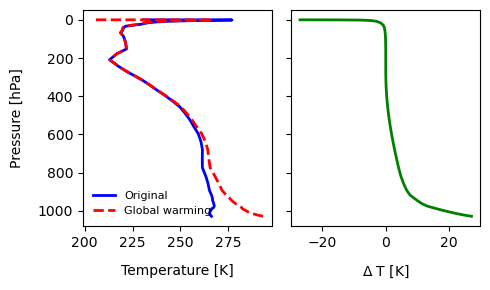

In [624]:
atm = 'CIRC4'
test = load(atmosphere=atm)
test = test.loc[test['level'] == 'SFC']
warmed = temp_change(test, 3)

plot_temp(test, warmed, savefig=True)

del test, warmed

### General information and assumptions

In [545]:
print('Wavenumber spectrum: 0 to 3000 cm^-1')
print('Wavelength spectrum: {0:.1e} to {1:.1e} m'.format(converter(3000, 'wavenumber', 'wavelength'), converter(1, 'wavenumber', 'wavelength')))

Wavenumber spectrum: 0 to 3000 cm^-1
Wavelength spectrum: 3.3e-06 to 1.0e-02 m


### Assignment responses

#### Pre-project, Problem 1

##### Pre-project, Problem 1a, CIRC2

In [546]:
flux_circ2_all = main(atmosphere='CIRC2', gas=None, bands='all')
print('CIRC2 flux: {0:.2f} W m^-2 | Stefan-Boltzmann flux: {1:.2f} W m^-2 | Error: {2:.2f} %'.format(flux_circ2_all, sb(307.74), 100*(flux_circ2_all-sb(307.74))/sb(307.74)))
del flux_circ2_all 

CIRC2 flux: 508.82 W m^-2 | Stefan-Boltzmann flux: 508.53 W m^-2 | Error: 0.06 %


##### Pre-project, Problem 1b, CIRC4

In [547]:
flux_circ4_all = main(atmosphere='CIRC4', gas=None, bands='all')
print('CIRC4 flux: {0:.2f} W m^-2 | Stefan-Boltzmann flux: {1:.2f} W m^-2 | Error: {2:.2f} %'.format(flux_circ4_all, sb(266.55), 100*(flux_circ4_all-sb(266.65))/sb(266.65)))
del flux_circ4_all

CIRC4 flux: 286.63 W m^-2 | Stefan-Boltzmann flux: 286.22 W m^-2 | Error: -0.01 %


#### Pre-project, Problem 2

##### Pre-project, Problem 2a, CIRC2

In [720]:
pp2_circ2_baseline = [] 
pp2_circ2_dT1 = [] 

for band in range(1, 15):
    flux_circ2_all_baseline = main(atmosphere='CIRC2', gas=None, bands=band)
    flux_circ2_all_dT = main(atmosphere='CIRC2', gas=None, bands=band, dT=1)
    flux_circ2_abs_diff = flux_circ2_all_dT - flux_circ2_all_baseline
    flux_circ2_pct_diff = 100*(flux_circ2_all_dT - flux_circ2_all_baseline)/flux_circ2_all_baseline
    # Store data
    pp2_circ2_baseline.append(flux_circ2_all_baseline)
    pp2_circ2_dT1.append(flux_circ2_all_dT)
    print('Band {0:2d} | Baseline flux: {1:6.2f} W m^-2 | dT+1 flux: {2:6.2f} W m^-2 | Abs. diff.: {3:6.2f} W m^-2 | % diff.: {4:6.2f} %'.format(band, flux_circ2_all_baseline, flux_circ2_all_dT, flux_circ2_abs_diff, flux_circ2_pct_diff))
    
del flux_circ2_all_baseline, flux_circ2_all_dT, flux_circ2_abs_diff, flux_circ2_pct_diff

Band  1 | Baseline flux:   8.82 W m^-2 | dT+1 flux:   8.85 W m^-2 | Abs. diff.:   0.04 W m^-2 | % diff.:   0.43 %
Band  2 | Baseline flux: 149.35 W m^-2 | dT+1 flux: 150.42 W m^-2 | Abs. diff.:   1.07 W m^-2 | % diff.:   0.72 %
Band  3 | Baseline flux:  36.37 W m^-2 | dT+1 flux:  36.73 W m^-2 | Abs. diff.:   0.35 W m^-2 | % diff.:   0.97 %
Band  4 | Baseline flux:  35.95 W m^-2 | dT+1 flux:  36.33 W m^-2 | Abs. diff.:   0.38 W m^-2 | % diff.:   1.06 %
Band  5 | Baseline flux:  48.74 W m^-2 | dT+1 flux:  49.31 W m^-2 | Abs. diff.:   0.57 W m^-2 | % diff.:   1.18 %
Band  6 | Baseline flux:  43.97 W m^-2 | dT+1 flux:  44.55 W m^-2 | Abs. diff.:   0.58 W m^-2 | % diff.:   1.32 %
Band  7 | Baseline flux:  34.66 W m^-2 | dT+1 flux:  35.16 W m^-2 | Abs. diff.:   0.51 W m^-2 | % diff.:   1.46 %
Band  8 | Baseline flux:  26.71 W m^-2 | dT+1 flux:  27.13 W m^-2 | Abs. diff.:   0.42 W m^-2 | % diff.:   1.58 %
Band  9 | Baseline flux:  35.47 W m^-2 | dT+1 flux:  36.08 W m^-2 | Abs. diff.:   0.62 W

##### Pre-project, Problem 2b, CIRC4

In [719]:
pp2_circ4_baseline = [] 
pp2_circ4_dT1 = [] 

for band in range(1, 15):
    flux_circ4_all_baseline = main(atmosphere='CIRC4', gas=None, bands=band)
    flux_circ4_all_dT = main(atmosphere='CIRC4', gas=None, bands=band, dT=1)
    flux_circ4_abs_diff = flux_circ4_all_dT - flux_circ4_all_baseline
    flux_circ4_pct_diff = 100*(flux_circ4_all_dT - flux_circ4_all_baseline)/flux_circ4_all_baseline
    # Store data
    pp2_circ4_baseline.append(flux_circ4_all_baseline)
    pp2_circ4_dT1.append(flux_circ4_all_dT)
    print('Band {0:2d} | Baseline flux: {1:6.2f} W m^-2 | dT+1 flux: {2:6.2f} W m^-2 | Abs. diff.: {3:6.2f} W m^-2 | % diff.: {4:6.2f} %'.format(band, flux_circ4_all_baseline, flux_circ4_all_dT, flux_circ4_abs_diff, flux_circ4_pct_diff))
    
del flux_circ4_all_baseline, flux_circ4_all_dT, flux_circ4_abs_diff, flux_circ4_pct_diff

Band  1 | Baseline flux:   7.27 W m^-2 | dT+1 flux:   7.30 W m^-2 | Abs. diff.:   0.04 W m^-2 | % diff.:   0.51 %
Band  2 | Baseline flux: 107.20 W m^-2 | dT+1 flux: 108.17 W m^-2 | Abs. diff.:   0.97 W m^-2 | % diff.:   0.91 %
Band  3 | Baseline flux:  23.13 W m^-2 | dT+1 flux:  23.42 W m^-2 | Abs. diff.:   0.29 W m^-2 | % diff.:   1.26 %
Band  4 | Baseline flux:  21.85 W m^-2 | dT+1 flux:  22.15 W m^-2 | Abs. diff.:   0.30 W m^-2 | % diff.:   1.39 %
Band  5 | Baseline flux:  28.00 W m^-2 | dT+1 flux:  28.43 W m^-2 | Abs. diff.:   0.43 W m^-2 | % diff.:   1.55 %
Band  6 | Baseline flux:  23.60 W m^-2 | dT+1 flux:  24.01 W m^-2 | Abs. diff.:   0.41 W m^-2 | % diff.:   1.75 %
Band  7 | Baseline flux:  17.41 W m^-2 | dT+1 flux:  17.75 W m^-2 | Abs. diff.:   0.34 W m^-2 | % diff.:   1.93 %
Band  8 | Baseline flux:  12.64 W m^-2 | dT+1 flux:  12.91 W m^-2 | Abs. diff.:   0.27 W m^-2 | % diff.:   2.11 %
Band  9 | Baseline flux:  15.61 W m^-2 | dT+1 flux:  15.97 W m^-2 | Abs. diff.:   0.36 W

### Project

#### Problem 1

Magnitudes may be accurate (see Pavlakis et al., 2004; Zhang et al. 10.1029/94JD027471, Lecture 6/7, Slide 28 from David Paynter)

In [661]:
# List gases of interest
gases = ['CO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List bands
bands = range(1, 15)
# Initialize dictionary
p1 = {}

for atm in atms:
    p1[atm] = {}
    for gas in gases:
        p1[atm][gas] = {}
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc')
        print('Atmospheric profile: {0} | Gas: {1:6} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            # Store data
            p1[atm][gas]['band_{0}'.format(band)] = {'toa': 0, 'sfc': 0}
            p1[atm][gas]['band_{0}'.format(band)]['toa'] = f_toa
            p1[atm][gas]['band_{0}'.format(band)]['sfc'] = f_sfc
            
            # print('\t Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
        
p1 = pd.DataFrame.from_dict({(i,j,k): p1[i][j][k]
                                for i in p1.keys()
                                for j in p1[i].keys()
                                for k in p1[i][j].keys()},
                               orient='index')
        
del gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: CO2    | Flux at TOA: 407.60 W m^-2 | Flux at surface: 209.70 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Flux at TOA: 267.72 W m^-2 | Flux at surface: 718.43 W m^-2
Atmospheric profile: CIRC2 | Gas: CH4    | Flux at TOA: 487.45 W m^-2 | Flux at surface:  26.23 W m^-2
Atmospheric profile: CIRC2 | Gas: N2O    | Flux at TOA: 465.56 W m^-2 | Flux at surface:  53.97 W m^-2
Atmospheric profile: CIRC2 | Gas: O3     | Flux at TOA: 425.32 W m^-2 | Flux at surface:  54.95 W m^-2
Atmospheric profile: CIRC2 | Gas: ALLGAS | Flux at TOA: 202.24 W m^-2 | Flux at surface: 750.78 W m^-2
Atmospheric profile: CIRC4 | Gas: CO2    | Flux at TOA: 258.45 W m^-2 | Flux at surface: 138.39 W m^-2
Atmospheric profile: CIRC4 | Gas: H2OCTM | Flux at TOA: 221.72 W m^-2 | Flux at surface: 351.47 W m^-2
Atmospheric profile: CIRC4 | Gas: CH4    | Flux at TOA: 284.45 W m^-2 | Flux at surface:  16.39 W m^-2
Atmospheric profile: CIRC4 | Gas: N2O    | Flux at TOA: 279.88 W m^-2 | F

#### Problem 2

H2O continuum alone

In [591]:
# List gases of interest
gases = ['H2OCTM', 'H2O']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)
# Initialize dictionary
p2 = {}

for atm in atms:
    p2[atm] = {}
    for gas in gases:
        p2[atm][gas] = {}
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            print('Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
            # Store data
            p2[atm][gas]['band_{0}'.format(band)] = {'toa': 0, 'sfc': 0}
            p2[atm][gas]['band_{0}'.format(band)]['toa'] = f_toa
            p2[atm][gas]['band_{0}'.format(band)]['sfc'] = f_sfc
        
p2 = pd.DataFrame.from_dict({(i,j,k): p2[i][j][k]
                                for i in p2.keys()
                                for j in p2[i].keys()
                                for k in p2[i][j].keys()},
                               orient='index')   
        
del bands, gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   1 | Flux at TOA:  11.21 W m^-2 | Flux at surface:  36.34 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   2 | Flux at TOA:  68.65 W m^-2 | Flux at surface: 280.97 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   3 | Flux at TOA:  20.48 W m^-2 | Flux at surface:  51.35 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   4 | Flux at TOA:  21.31 W m^-2 | Flux at surface:  44.50 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   5 | Flux at TOA:  31.52 W m^-2 | Flux at surface:  51.88 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   6 | Flux at TOA:  31.26 W m^-2 | Flux at surface:  41.14 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   7 | Flux at TOA:  25.53 W m^-2 | Flux at surface:  30.03 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   8 | Flux at TOA:  19.36 W m^-2 | Flux at surface:  22.21 W m^-2
Atmospheric profile: CIRC2 | Gas: H2OCTM | Band:   9 | Flux at TOA:  22.52 W m^-

#### Problem 3

##### Problem 3a

2xCO2 alone

In [592]:
# List gases of interest
gases = ['2xCO2', 'CO2']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)
# Initialize dictionary
p3a = {}

for atm in atms:
    p3a[atm] = {}
    for gas in gases:
        p3a[atm][gas] = {}
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            print('Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
            # Store data
            p3a[atm][gas]['band_{0}'.format(band)] = {'toa': 0, 'sfc': 0}
            p3a[atm][gas]['band_{0}'.format(band)]['toa'] = f_toa
            p3a[atm][gas]['band_{0}'.format(band)]['sfc'] = f_sfc
        
p3a = pd.DataFrame.from_dict({(i,j,k): p3a[i][j][k]
                              for i in p3a.keys()
                              for j in p3a[i].keys()
                              for k in p3a[i][j].keys()},
                             orient='index')   
        
del bands, gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   1 | Flux at TOA:  18.93 W m^-2 | Flux at surface:   0.01 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   2 | Flux at TOA: 145.63 W m^-2 | Flux at surface:  26.40 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   3 | Flux at TOA:  12.01 W m^-2 | Flux at surface:  40.60 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   4 | Flux at TOA:  15.81 W m^-2 | Flux at surface:  67.59 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   5 | Flux at TOA:  12.83 W m^-2 | Flux at surface:  53.28 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   6 | Flux at TOA:  40.66 W m^-2 | Flux at surface:  10.43 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   7 | Flux at TOA:  27.13 W m^-2 | Flux at surface:  14.23 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   8 | Flux at TOA:  20.65 W m^-2 | Flux at surface:  10.15 W m^-2
Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   9 | Flux at TOA:  31.12 W m^-

##### Problem 3b
_Generate data files for the 2xCO2 cases._

In [710]:
atm_profiles = ['CIRC2', 'CIRC4']
levels = ['SFC', 'TOA']

for atm_profile in atm_profiles:
    for level in levels:
        
        baseline = load(atmosphere=atm_profile, gas_name='ALLGAS')
        baseline_2xco2 = baseline.copy().loc[baseline['level'] == level].set_index('layer_pres')
        baseline_2xco2_h2o_lines = baseline.copy().loc[baseline['level'] == level].set_index('layer_pres')
        
        co2 = load(atmosphere=atm_profile, gas_name='CO2')
        co2 = co2.loc[co2['level'] == level].set_index('layer_pres').iloc[:, 2:-3]
        co2x2 = load(atmosphere=atm_profile, gas_name='2xCO2')
        co2x2 = co2x2.loc[co2x2['level'] == level].set_index('layer_pres').iloc[:, 2:-3]
        
        h2o = load(atmosphere=atm_profile, gas_name='H2O')
        h2o = h2o.loc[h2o['level'] == level].set_index('layer_pres').iloc[:, 2:-3]
        h2octm = load(atmosphere=atm_profile, gas_name='H2OCTM')
        h2octm = h2octm.loc[h2octm['level'] == level].set_index('layer_pres').iloc[:, 2:-3]
        
        # Divide out the CO2 transmittances
        baseline_2xco2.iloc[:, 2:-3] = baseline_2xco2.iloc[:, 2:-3]*co2x2/co2
        baseline_2xco2 = baseline_2xco2.reset_index()
        fname = 'data/{0}_LAYER_ALLGAS2XCO2_{1}.csv'.format(atm_profile, level)
        baseline_2xco2.where(baseline_2xco2['level'] == level).dropna().to_csv(fname, index=False);
        
        # Divide out the CO2 transmittances
        baseline_2xco2_h2o_lines.iloc[:, 2:-3] = baseline_2xco2_h2o_lines.iloc[:, 2:-3]*co2x2*h2o/(co2*h2octm)
        baseline_2xco2_h2o_lines = baseline_2xco2_h2o_lines.reset_index()
        fname = 'data/{0}_LAYER_ALLGAS2XCO2LINES_{1}.csv'.format(atm_profile, level)
        baseline_2xco2_h2o_lines.where(baseline_2xco2_h2o_lines['level'] == level).dropna().to_csv(fname, index=False);
        
        
del atm_profiles, levels, baseline, baseline_2xco2, baseline_2xco2_h2o_lines, h2o, h2octm, co2, co2x2, fname

All gases, except CO2 is now 2xCO2. To get 2xCO2's effect on fluxes, double the CO2 concentration in the 'ALLGAS' case. To do so, divide the CO2 transmittances from the 'ALLGAS' case and multiply by the 2xCO2 transmittances.

In [714]:
# List gases of interest
gases = ['2xCO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)
# Initialize dictionary
p3b = {}

for atm in atms:
    p3b[atm] = {}
    for gas in gases:
        p3b[atm][gas] = {}
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc')
        print('Atmospheric profile: {0} | Gas: {1:11} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            print('\t Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
            # Store data
            p3b[atm][gas]['band_{0}'.format(band)] = {'toa': 0, 'sfc': 0}
            p3b[atm][gas]['band_{0}'.format(band)]['toa'] = f_toa
            p3b[atm][gas]['band_{0}'.format(band)]['sfc'] = f_sfc
            
p3b = pd.DataFrame.from_dict({(i,j,k): p3b[i][j][k]
                  for i in p3b.keys()
                  for j in p3b[i].keys()
                  for k in p3b[i][j].keys()},
                 orient='index')   
            
del gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: 2xCO2       | Flux at TOA: 392.02 W m^-2 | Flux at surface: 246.72 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   1 | Flux at TOA:  18.93 W m^-2 | Flux at surface:   0.01 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   2 | Flux at TOA: 145.63 W m^-2 | Flux at surface:  26.40 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   3 | Flux at TOA:  12.01 W m^-2 | Flux at surface:  40.60 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   4 | Flux at TOA:  15.81 W m^-2 | Flux at surface:  67.59 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   5 | Flux at TOA:  12.83 W m^-2 | Flux at surface:  53.28 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   6 | Flux at TOA:  40.66 W m^-2 | Flux at surface:  10.43 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   7 | Flux at TOA:  27.13 W m^-2 | Flux at surface:  14.23 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   8 | Flux at TOA:  20

##### Problem 3c

All gases, except CO2 is now 2xCO2, and H2OCTM is now H2O.

In [715]:
# List gases of interest
gases = ['2xCO2', 'H2O', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2LINES']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List of bands of interest
bands = range(1, 15)
# Initialize dictionary
p3c = {}

for atm in atms:
    p3c[atm] = {}
    for gas in gases:
        p3c[atm][gas] = {}
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc')
        print('Atmospheric profile: {0} | Gas: {1:6} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            print('\t Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
            # Store data
            p3c[atm][gas]['band_{0}'.format(band)] = {'toa': 0, 'sfc': 0}
            p3c[atm][gas]['band_{0}'.format(band)]['toa'] = f_toa
            p3c[atm][gas]['band_{0}'.format(band)]['sfc'] = f_sfc
            
p3c = pd.DataFrame.from_dict({(i,j,k): p3c[i][j][k]
                  for i in p3c.keys()
                  for j in p3c[i].keys()
                  for k in p3c[i][j].keys()},
                 orient='index')               

del bands, gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: 2xCO2  | Flux at TOA: 392.02 W m^-2 | Flux at surface: 246.72 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   1 | Flux at TOA:  18.93 W m^-2 | Flux at surface:   0.01 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   2 | Flux at TOA: 145.63 W m^-2 | Flux at surface:  26.40 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   3 | Flux at TOA:  12.01 W m^-2 | Flux at surface:  40.60 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   4 | Flux at TOA:  15.81 W m^-2 | Flux at surface:  67.59 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   5 | Flux at TOA:  12.83 W m^-2 | Flux at surface:  53.28 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   6 | Flux at TOA:  40.66 W m^-2 | Flux at surface:  10.43 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   7 | Flux at TOA:  27.13 W m^-2 | Flux at surface:  14.23 W m^-2
	 Atmospheric profile: CIRC2 | Gas: 2xCO2  | Band:   8 | Flux at TOA:  20.65 W

#### Problem 4

##### Generate temperatures in a global warming case

In [597]:
# Generate temperatures from any gas data for each atmosphere (all profiles are the same at SFC and TOA)
sample_circ2 = load(atmosphere='CIRC2')
sample_circ2 = sample_circ2.loc[sample_circ2['level'] == 'SFC']
sample_circ4 = load(atmosphere='CIRC4')
sample_circ4 = sample_circ4.loc[sample_circ4['level'] == 'SFC']
# Generate updated temperature profiles (cubic function offset)
T_gw_circ2 = temp_change(sample_circ2, 3)
T_gw_circ4 = temp_change(sample_circ4, 2)

del sample_circ2, sample_circ4

#### Problem 4a
Quantify the change at surface and TOA of each band to these alterations - all gases

In [627]:
# List gases of interest
gases = ['ALLGAS']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List custom temperature profiles rep. of global warming
Ts = {'CIRC2': T_gw_circ2, 'CIRC4': T_gw_circ4}
# Bands
bands = range(1, 15)
# Initialize dictionary
p4a = {}

for atm in atms:
    p4a[atm] = {}
    for gas in gases:
        p4a[atm][gas] = {}
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa', custom_temps=Ts[atm]), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc', custom_temps=Ts[atm])
        print('Atmospheric profile: {0} | Gas: {1:6} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa', custom_temps=Ts[atm]), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc', custom_temps=Ts[atm])
            print('\t Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
            # Store data
            p4a[atm][gas]['band_{0}'.format(band)] = {'toa': 0, 'sfc': 0}
            p4a[atm][gas]['band_{0}'.format(band)]['toa'] = f_toa
            p4a[atm][gas]['band_{0}'.format(band)]['sfc'] = f_sfc
        
p4a = pd.DataFrame.from_dict({(i,j,k): p4a[i][j][k]
                  for i in p4a.keys()
                  for j in p4a[i].keys()
                  for k in p4a[i][j].keys()},
                 orient='index')    
        
del gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: ALLGAS | Flux at TOA: 211.21 W m^-2 | Flux at surface: 961.85 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   1 | Flux at TOA:  11.22 W m^-2 | Flux at surface:  40.12 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   2 | Flux at TOA:  68.56 W m^-2 | Flux at surface: 327.99 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   3 | Flux at TOA:  11.89 W m^-2 | Flux at surface:  66.08 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   4 | Flux at TOA:  13.61 W m^-2 | Flux at surface:  82.56 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   5 | Flux at TOA:  12.82 W m^-2 | Flux at surface:  71.89 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   6 | Flux at TOA:  35.31 W m^-2 | Flux at surface:  51.45 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   7 | Flux at TOA:  26.61 W m^-2 | Flux at surface:  37.89 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS | Band:   8 | Flux at TOA:   5.02 W

Quantify effect of altered temperature profile relative to Part 1 of the project

In [630]:
atm = 'CIRC4'
gas_name = 'ALLGAS'
(p4a.xs(atm).xs(gas_name) - p1.xs(atm).xs(gas_name))

,toa,sfc
band_1,-0.018566,1.092779
band_2,-0.076900,10.506487
band_3,-0.081883,2.046030
band_4,-0.470479,3.899236
band_5,-0.114523,2.519301
band_6,2.224197,0.216313
band_7,1.416129,0.047662
band_8,-0.132970,0.289641
band_9,0.449012,0.459818
band_10,-0.003970,2.711324


#### Problem 4b
Quantify the change at surface and TOA of each band to these alterations - all gases bar H2O

_Generate data files for the ALLGAS - H2O case. Assume that ALLGAS incorporates H2OCTM._

In [599]:
atm_profiles = ['CIRC2', 'CIRC4']
levels = ['SFC', 'TOA']

for atm_profile in atm_profiles:
    for level in levels:
        
        baseline = load(atmosphere=atm_profile, gas_name='ALLGAS')
        baseline_noh2o = baseline.copy().loc[baseline['level'] == level].set_index('layer_pres')
        
        h2o = load(atmosphere=atm_profile, gas_name='H2OCTM')
        h2o = h2o.loc[h2o['level'] == level].set_index('layer_pres').iloc[:, 2:-3]
        
        # Divide out the H2O transmittances
        baseline_noh2o.iloc[:, 2:-3] = baseline_noh2o.iloc[:, 2:-3]/h2o
        baseline_noh2o = baseline_noh2o.reset_index()
        fname = 'data/{0}_LAYER_ALLGAS-NOH2O_{1}.csv'.format(atm_profile, level)
        baseline_noh2o.where(baseline_noh2o['level'] == level).dropna().to_csv(fname, index=False);
        
del atm_profiles, levels, baseline, baseline_noh2o, h2o

In [600]:
# List gases of interest
gases = ['ALLGAS-NOH2O']
# List atmospheres of interest
atms = ['CIRC2', 'CIRC4']
# List custom temperature profiles rep. of global warming
Ts = {'CIRC2': T_gw_circ2, 'CIRC4': T_gw_circ4}
# Bands
bands = range(1, 15)
# Initialize dictionary
p4b = {}

for atm in atms:
    p4b[atm] = {}
    for gas in gases:
        p4b[atm][gas] = {}
        f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='toa', custom_temps=Ts[atm]), flux_layered(atmosphere=atm, gas_name=gas, bands='all', z='sfc', custom_temps=Ts[atm])
        print('Atmospheric profile: {0} | Gas: {1:6} | Flux at TOA: {2:6.2f} W m^-2 | Flux at surface: {3:6.2f} W m^-2'.format(atm, gas, f_toa, f_sfc))
        for band in bands:
            f_toa, f_sfc = flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='toa'), flux_layered(atmosphere=atm, gas_name=gas, bands=band, z='sfc')
            print('\t Atmospheric profile: {0} | Gas: {1:6} | Band: {2:3} | Flux at TOA: {3:6.2f} W m^-2 | Flux at surface: {4:6.2f} W m^-2'.format(atm, gas, band, f_toa, f_sfc))
            # Store data
            p4b[atm][gas]['band_{0}'.format(band)] = {'toa': 0, 'sfc': 0}
            p4b[atm][gas]['band_{0}'.format(band)]['toa'] = f_toa
            p4b[atm][gas]['band_{0}'.format(band)]['sfc'] = f_sfc
        

p4b = pd.DataFrame.from_dict({(i,j,k): p4b[i][j][k]
                  for i in p4b.keys()
                  for j in p4b[i].keys()
                  for k in p4b[i][j].keys()},
                 orient='index')    
        
del gases, gas, atms, atm, f_toa, f_sfc

Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Flux at TOA: 347.56 W m^-2 | Flux at surface: 439.56 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Band:   1 | Flux at TOA:  11.27 W m^-2 | Flux at surface:  36.34 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Band:   2 | Flux at TOA: 128.90 W m^-2 | Flux at surface:  93.43 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Band:   3 | Flux at TOA:  12.13 W m^-2 | Flux at surface:  39.10 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Band:   4 | Flux at TOA:  14.82 W m^-2 | Flux at surface:  63.96 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Band:   5 | Flux at TOA:  13.05 W m^-2 | Flux at surface:  48.52 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Band:   6 | Flux at TOA:  42.05 W m^-2 | Flux at surface:   5.39 W m^-2
	 Atmospheric profile: CIRC2 | Gas: ALLGAS-NOH2O | Band:   7 | Flux at TOA:  26.81 W m^-2 | Flux at surface:  11.59 W m^-2
	 Atmospheric profile: CIRC2 |

### Data visualization
Playing around with all the saved data

##### Get band average wavenumbers

In [601]:
wns = band_info(band='all')['mean']/100

In [602]:
def multilevel_plot(data=None, gases=None, atm=None, levels=None):
    fig, ax = plt.subplots(figsize=(6, 3), ncols=2, sharey=True)
    colors = ['r', 'b', 'g', 'blueviolet', 'darkorange', 'k']

    for i, level in enumerate(levels):
        subdata = data.xs(atm)
        for c, gas in enumerate(gases):
            lw = 3 if 'ALLGAS' in gas else 1
            label = gas if i == 0 else None
            # Consider adding some way to color the dots to indicate transmission, maybe make the markers distinct per gas
            ax[i].plot(wns, subdata.xs(gas)[level], c=colors[c], label=label, lw=lw, zorder=10)

        title_str = 'Top of atmosphere' if level == 'toa' else 'Surface'
        ax[i].set_title(title_str, pad = 10)
        # ax[i].set_yscale('log') 
        ax[i].grid()

    labelpad = 10
    ax[0].set_ylabel('Flux (F) [W m$^{-2}$]', labelpad=labelpad)

    fig.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 0.92))
    fig.tight_layout()
    fig.supxlabel('Wavenumber [cm $^{-1}$]', x=0.55, y=-0.1, fontsize=10)

In [612]:
def transmittance_plot(atmosphere=None, gas_names=None, level=None, savefig=True):
    ''' Modeled to look like the plot in Petty, Fig. 7.6. '''
    
    if type(gas_names) is not list:
        gas_names = [gas_names]
        
    # Generate wavenumbers
    wns = band_info(band='all')['mean']/100
        
    fig, ax = plt.subplots(figsize=(4, 1*len(gas_names)), nrows=len(gas_names), sharex=True)
    for row, gas in enumerate(gas_names):
        tmp = load(atmosphere=atmosphere, gas_name=gas)
        # Isolate band data
        tmp_bands = tmp.copy().loc[tmp['level'] == level]
        tmp_bands = tmp_bands.iloc[:, 2:-3].max()
        ax[row].plot(converter(wns, 'wavenumber', 'wavelength'), tmp_bands, color='k', lw=2, label=gas, marker='o', markersize=5)
        
        legend = ax[row].legend(handlelength=0, handletextpad=0, frameon=False, loc='right')
        [item.set_visible(False) for item in legend.legendHandles]
        
        ax[row].set_ylim([0, 1.1])
        ax[row].grid(which='both', ls=':', alpha=0.5)
        ax[row].set_xscale('log')
        ax[row].xaxis.set_major_formatter(mtk.FormatStrFormatter('%.2e'))
        
        if row != 0:
            ax[row].yaxis.get_major_ticks()[-1].label1.set_visible(False)
            
    fig.suptitle('Transmittance at {0}, {1}'.format(level, atmosphere))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    
    fig.supxlabel('Wavelength ($\lambda$) [m]', y=-0.05)
    fig.supylabel('Transmittance', x=-0.1)
    
    if savefig:
        plt.savefig('figs/transmittance_{0}_{1}.png'.format(atmosphere, level), bbox_inches='tight', dpi=300)

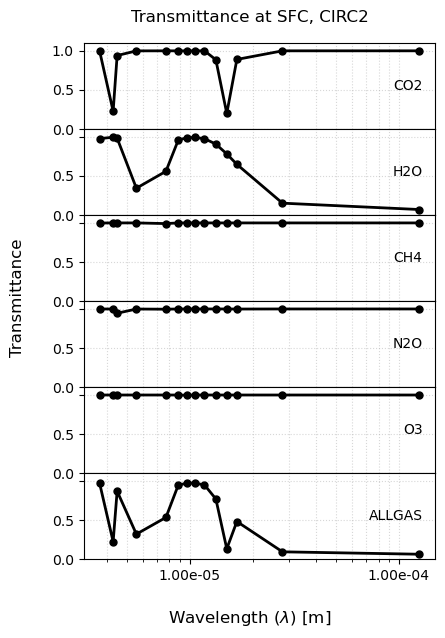

In [613]:
transmittance_plot(atmosphere='CIRC2', gas_names=['CO2', 'H2O', 'CH4', 'N2O', 'O3', 'ALLGAS'], level='SFC', savefig=True)

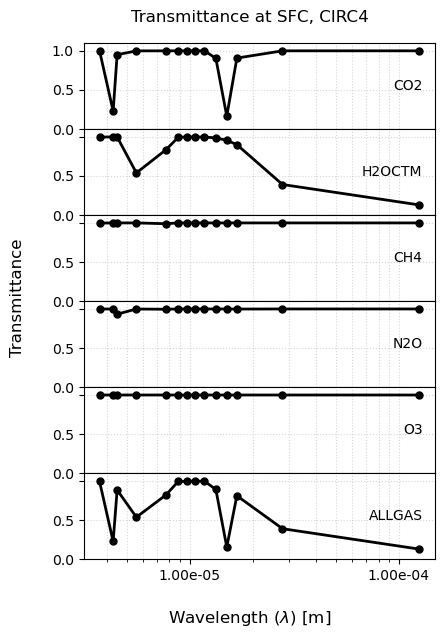

In [614]:
transmittance_plot(atmosphere='CIRC4', gas_names=['CO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS'], level='SFC', savefig=True)

##### Pre-project 2: calculated fluxes versus Stefan-Boltzmann, CIRC2

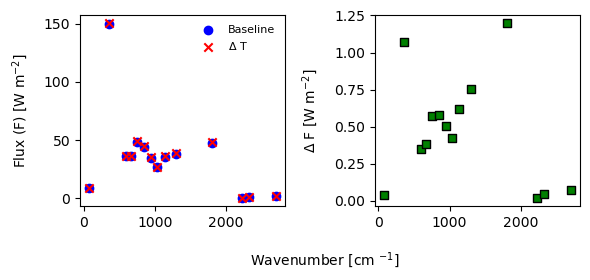

In [582]:
fig, ax = plt.subplots(figsize=(6, 2.5), ncols=2)
im_base = ax[0].scatter(wns, pp2_circ2_baseline, marker='o', c='b', label='Baseline')
    # Consider adding some way to color the dots to indicate transmission, maybe make the markers distinct per level
im_dT = ax[0].scatter(wns, pp2_circ2_dT1, marker='x', c='r', label='$\Delta$ T')
delta = ax[1].scatter(wns, np.array(pp2_circ2_dT1) - np.array(pp2_circ2_baseline) , marker='s', ec='k', c='g')

labelpad = 10
ax[0].set_ylabel('Flux (F) [W m$^{-2}$]', labelpad=labelpad)
ax[1].set_ylabel('$\Delta$ F [W m$^{-2}$]', labelpad=labelpad)

ax[0].legend(fontsize=8, frameon=False)
fig.tight_layout()
fig.supxlabel('Wavenumber [cm $^{-1}$]', x=0.55, y=-0.1, fontsize=10)

plt.savefig('figs/pp2_circ2.png', bbox_inches='tight', dpi=300)

##### Pre-project 2: calculated fluxes versus Stefan-Boltzmann, CIRC4

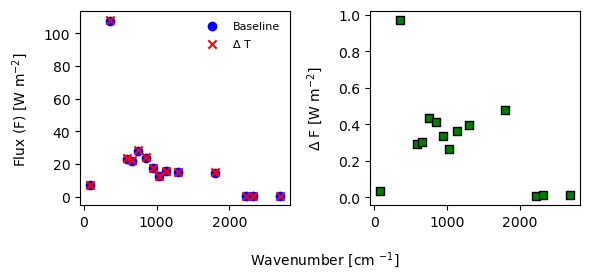

In [583]:
fig, ax = plt.subplots(figsize=(6, 2.5), ncols=2)
im_base = ax[0].scatter(wns, pp2_circ4_baseline, marker='o', c='b', label='Baseline')
im_dT = ax[0].scatter(wns, pp2_circ4_dT1, marker='x', c='r', label='$\Delta$ T')
delta = ax[1].scatter(wns, np.array(pp2_circ4_dT1) - np.array(pp2_circ4_baseline) , marker='s', ec='k', c='g')

labelpad = 10
ax[0].set_ylabel('Flux (F) [W m$^{-2}$]', labelpad=labelpad)
ax[1].set_ylabel('$\Delta$ F [W m$^{-2}$]', labelpad=labelpad)

ax[0].legend(fontsize=8, frameon=False)
fig.tight_layout()
fig.supxlabel('Wavenumber [cm $^{-1}$]', x=0.55, y=-0.1, fontsize=10)

plt.savefig('figs/pp2_circ4.png', bbox_inches='tight', dpi=300)

##### Problem 1a: Fluxes for individual gases, and all together, CIRC2

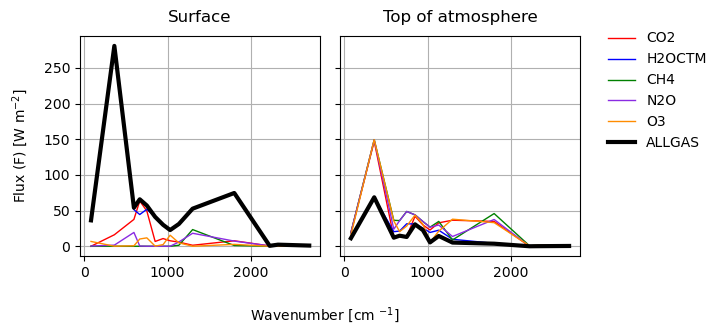

In [653]:
# List gases of interest
gases = ['CO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC2'

multilevel_plot(data=p1, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p1a_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

##### Problem 1b: Fluxes for individual gases, and all together, CIRC4

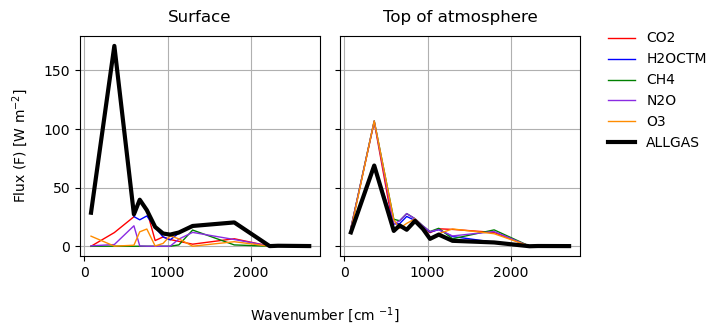

In [586]:
# List gases of interest
gases = ['CO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC4'

multilevel_plot(data=p1, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p1a_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

##### Problem 2: Fluxes for H2OCTM, CIRC2

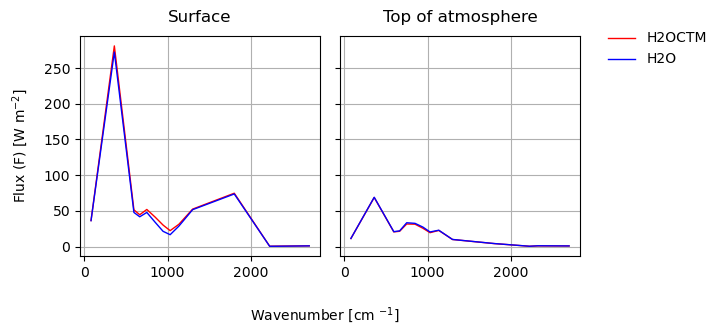

In [604]:
# List gases of interest
gases = ['H2OCTM', 'H2O']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC2'

multilevel_plot(data=p2, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p2_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

##### Problem 2: Fluxes for H2OCTM, CIRC4

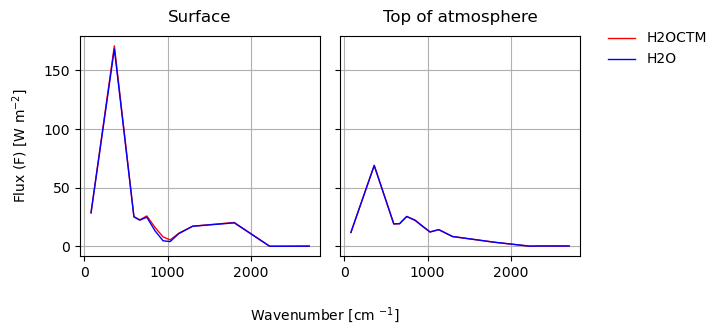

In [622]:
# List gases of interest
gases = ['H2OCTM', 'H2O']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC4'

multilevel_plot(data=p2, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p2_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

##### Problem 3a: fluxes for CO2 and 2XCO2

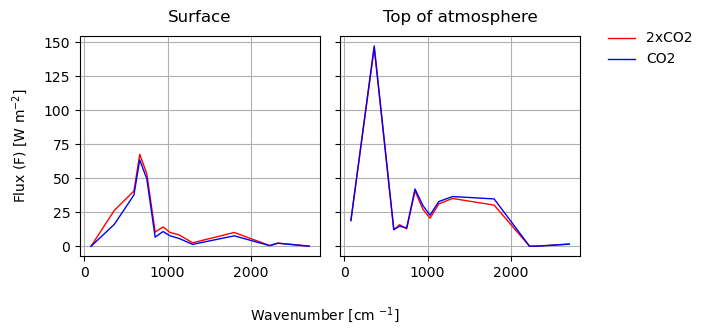

In [607]:
# List gases of interest
gases = ['2xCO2', 'CO2']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC2'

multilevel_plot(data=p3a, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p3a_co2_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

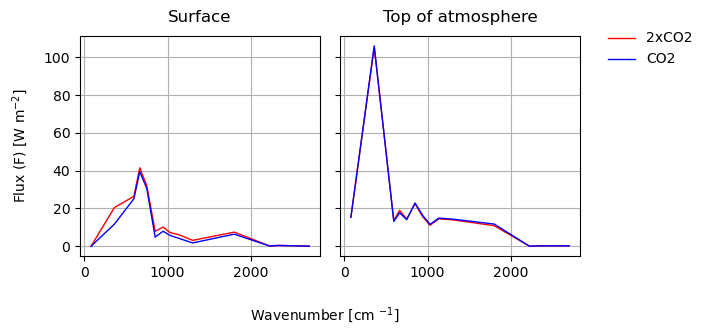

In [608]:
# List gases of interest
gases = ['2xCO2', 'CO2', ]
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC4'

multilevel_plot(data=p3a, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p3a_co2_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

##### Problem 3b: fluxes for all gases and 2XCO2, CIRC2

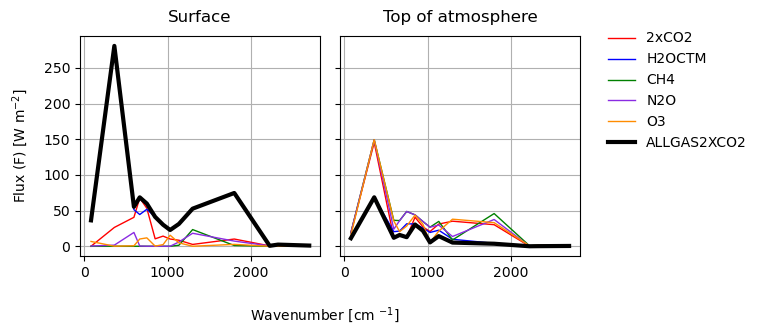

In [618]:
# List gases of interest
gases = ['2xCO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC2'

multilevel_plot(data=p3b, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p3b_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

##### Problem 3b: fluxes for all gases and 2XCO2, CIRC4

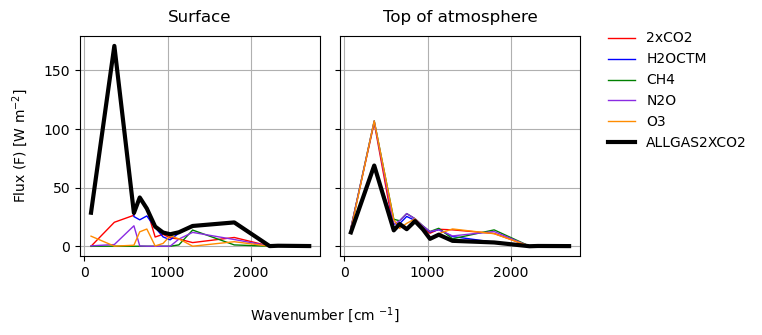

In [619]:
# List gases of interest
gases = ['2xCO2', 'H2OCTM', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC4'

multilevel_plot(data=p3b, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p3b_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

##### Problem 3c: fluxes for all gases and 2XCO2, water vapor lines, CIRC2

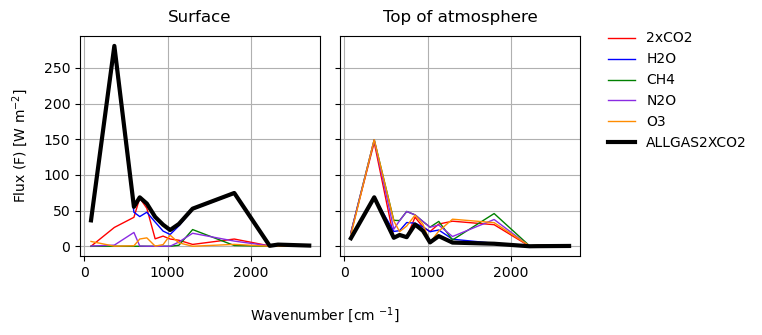

In [620]:
# List gases of interest
gases = ['2xCO2', 'H2O', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC2'

multilevel_plot(data=p3c, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p3c_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

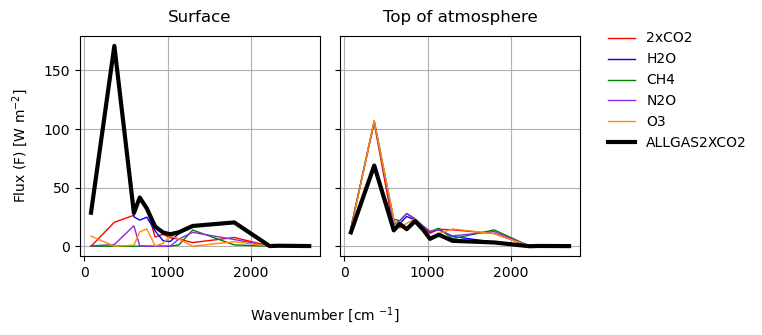

In [621]:
# List gases of interest
gases = ['2xCO2', 'H2O', 'CH4', 'N2O', 'O3', 'ALLGAS2XCO2']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC4'

multilevel_plot(data=p3c, gases=gases, atm=atm, levels=levels)

plt.savefig('figs/p3c_{0}.png'.format(atm), bbox_inches='tight', dpi=300)

                  toa       sfc
band_1   0.000000e+00  0.000000
band_2   3.058671e-01 -8.600082
band_3   6.830195e-04 -2.853668
band_4  -3.580825e-08 -0.183444
band_5   4.662740e-04 -2.211622
band_6   1.080252e+00 -6.952096
band_7   5.075346e-01 -6.944274
band_8   8.624677e-07 -2.946506
band_9   1.700750e-01 -2.409513
band_10  1.029130e-02 -0.761463
band_11  5.380317e-02 -1.036657
band_12  2.969542e-09 -0.002609
band_13  2.775558e-17 -0.000470
band_14  7.508585e-03 -0.049012


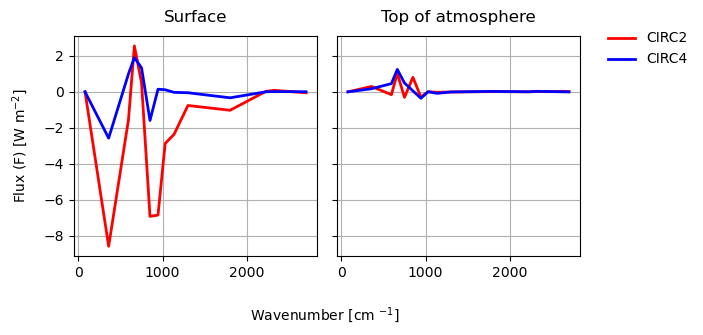

In [718]:
atm = 'CIRC2'
gas_name = 'ALLGAS'
diff_circ2 = (p3b.xs(atm).xs('ALLGAS2XCO2') - p1.xs(atm).xs(gas_name))
diff_circ2_c = (p3c.xs(atm).xs('ALLGAS2XCO2LINES') - p1.xs(atm).xs(gas_name))

atm = 'CIRC4'
gas_name = 'ALLGAS'
diff_circ4 = (p3b.xs(atm).xs('ALLGAS2XCO2') - p1.xs(atm).xs(gas_name))
diff_circ4_c = (p3c.xs(atm).xs('ALLGAS2XCO2LINES') - p1.xs(atm).xs(gas_name))

print(diff_circ2_c - diff_circ2)

diff_data = [diff_circ2_c, diff_circ4_c]

fig, ax = plt.subplots(figsize=(6, 3), ncols=2, sharey=True)
colors = ['r', 'b', 'g', 'blueviolet', 'darkorange', 'k']
levels = ['sfc', 'toa']

for i, level in enumerate(levels):
    
    lw = 2
    labels = ['CIRC2', 'CIRC4'] if i == 0 else ['', '',]
    ax[i].plot(wns, diff_data[0][level], c=colors[0], label=labels[0], lw=lw, zorder=10)
    ax[i].plot(wns, diff_data[1][level], c=colors[1], label=labels[1], lw=lw, zorder=10)

    title_str = 'Top of atmosphere' if level == 'toa' else 'Surface'
    ax[i].set_title(title_str, pad = 10)
    ax[i].grid()

labelpad = 10
ax[0].set_ylabel('Flux (F) [W m$^{-2}$]', labelpad=labelpad)

fig.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 0.92))
fig.tight_layout()
fig.supxlabel('Wavenumber [cm $^{-1}$]', x=0.55, y=-0.1, fontsize=10)

# plt.savefig('figs/p3b_comp_linesctm.png', bbox_inches='tight', dpi=300)

#### Problem 4a

KeyError: 'CO2'

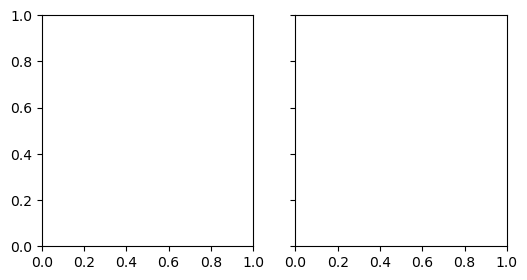

In [631]:
# List gases of interest
gases = ['CO2', 'H2O', 'CH4', 'N2O', 'O3', 'ALLGAS']
# List bands
bands = range(1, 15)
# Level
levels = ['sfc', 'toa']
# Atmospheric profile
atm = 'CIRC2'

multilevel_plot(data=p4a, gases=gases, atm=atm, levels=levels)

# plt.savefig('figs/p3c_{0}.png'.format(atm), bbox_inches='tight', dpi=300)